# Observer

This Observer notebook monitors USB cameras for changes on the DMA playing field.

In [1]:
import json
import cv2
from collections import defaultdict
import numpy as np
import imutils
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode as qrDecode
from math import cos, acos, degrees, radians
from time import sleep
from datetime import datetime
import requests
from dataclasses import dataclass
from traceback import format_exc
from uuid import uuid4

In [2]:
def distanceFormula(pt0, pt1):
    return sum([(pt1[i] - pt0[i])**2 for i in range(len(pt0))]) ** 0.5


def capture_camera(cam_num):
    try:
        cam = cv2.VideoCapture(cam_num)
        retval, image = cam.read()
    finally:
        cam.release()
    retval, buff = cv2.imencode('.jpg', image)
    return buff


MAX_CAM_ID = 10


def identify_usb_cameras(device_numbers=list(range(MAX_CAM_ID))):
    functional = []
    for dn in device_numbers:
        try:
            img = capture_camera(dn)
            functional.append(dn)
        except Exception as e:
            continue
    return functional


def hStackImages(images):
    if len(images) == 0:
        return np.zeros((1, 1), dtype="uint8")
    images = [image if image is not None else np.zeros((10, 10, 3), np.uint8) for image in images]
    baseIm = None
    maxHeight = max([im.shape[0] for im in images])
    for im in images:    
        if im.shape[0] < maxHeight:
            addition = np.zeros((maxHeight - im.shape[0], im.shape[1], 3), np.uint8)
            im = np.vstack((im, addition))
        if baseIm is None:
            baseIm = im
        else:
            baseIm = np.hstack((
                baseIm,
                np.zeros((maxHeight, 10, 3), np.uint8),
                im))
    return baseIm


def vStackImages(images):
    if len(images) == 0:
        return np.zeros((1, 1), dtype="uint8")
    images = [image if image is not None else np.zeros((10, 10, 3), np.uint8) for image in images]
    baseIm = None
    maxWidth = max([im.shape[1] for im in images])
    for im in images:    
        if im.shape[0] < maxWidth:
            addition = np.zeros((im.shape[0], maxWidth - im.shape[1], 3), np.uint8)
            im = np.hstack((im, addition))
        if baseIm is None:
            baseIm = im
        else:
            baseIm = np.vstack((
                baseIm,
                np.zeros((10, maxWidth, 3), np.uint8),
                im))
    return baseIm

In [3]:
@dataclass
class CameraChange:
    camName: str
    changeContours: np.array
    before: np.array
    after: np.array
    changeType: str = "unclassified"
    lastChange: object = None

    def __post_init__(self):
        if self.changeType is None:
            self.corner = None
            self.width = None
            self.height = None
            self.center = None
            self.before = None
            self.after = None
        else:
            self.area = max([cv2.contourArea(c) for c in self.changeContours])
            self.changePoints = np.array([pt for c in self.changeContours for d in c for pt in d], dtype="float32")
            xS = [pt[0] for pt in self.changePoints]
            yS = [pt[1] for pt in self.changePoints]
            minX = min(xS)
            minY = min(yS)
            self.corner = [minX, minY]
            self.width = max(xS) - minX
            self.height = max(yS) - minY
            self.center = [min(xS) + int(self.width / 2), min(yS) + int(self.height / 2)]
            self.before = self.before[int(minY):int(minY + self.height), int(minX):int(minX + self.width)]
            self.after = self.after[int(minY):int(minY + self.height), int(minX):int(minX + self.width)]
            self.clipBox = [int(i) for i in (*self.corner, self.width, self.height)]
    
    def classify(self, changeType: str, lastChange: object=None):
        assert self.changeType is not None, "Unable to classify null ChangeType"
        assert changeType in ["add", "move", "delete", "unclassified"]
        self.lastChange = lastChange
        self.changeType = changeType

    def changeOverlap(self, change):
        zeros = np.zeros(cameras[self.camName].mostRecentFrame.shape[:2], np.uint8)
        if self.changeType is None or change.changeType is None:
            return False
        changeIm = cv2.drawContours(zeros.copy(), self.changeContours, -1, 255, -1)
        otherIm = cv2.drawContours(zeros.copy(), change.changeContours, -1, 255, -1)
        overlap = cv2.bitwise_and(changeIm, otherIm)
        if overlap.any():
            contours = cv2.findContours(overlap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
            largestArea = max([cv2.contourArea(c) for c in contours])
            overlapRatio = largestArea / self.area
            if 0.1 < overlapRatio < 2.0:
                return True
            else:
                print(f"Overlap ratio is too low: {overlapRatio}")
        return False

    def __eq__(self, other):
        if self.changeType in [None, 'delete']:
            return other is None or other.changeType in [None, 'delete']
        elif other is not None and other.changeType not in [None, 'delete']:
            return \
            (other.center[0] - 20 < self.center[0] < other.center[0] + 20) and \
            (other.center[1] - 20 < self.center[1] < other.center[1] + 20) and \
            (other.width - 20 < self.width < other.width + 20) and \
            (other.height - 20 < self.height < other.height + 20) and self.changeOverlap(other)
        else:
            return False
    
    def __repr__(self):
        return f"({self.changeType}) {self.center} by {self.width},{self.height}"
    
    def beforeAfter(self):
        return hStackImages([self.before, self.after])

In [4]:
@dataclass
class Camera:
    camName: str
    activeZone: list
    
    IMAGE_BUFFER_DEPTH = 7
    CAPTURE_FRAMES = 3
    MILLIMETERS_PER_PIXEL = 2
    MI = 2
    xmax = 2560
    ymax = 1920

    def __post_init__(self):
        self.imageBuffer = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.referenceFrame = None
        self.baseFrame = None
        self.setActiveZone(self.activeZone)
        self.setReferenceFrame()
        self.setBaseFrame()
    
    @property
    def mostRecentFrame(self):
        return self.imageBuffer[0]
    
    def setBaseFrame(self):
        self.baseFrame = self.mostRecentFrame
    
    def setReferenceFrame(self):
        self.referenceFrame = self.imageBuffer[1] if self.imageBuffer[1] is not None else self.imageBuffer[0]
    
    def setActiveZone(self, newAZ):
        self.activeZone = np.float32(newAZ)
    
    def pointInActiveZone(self, p):
        return cv2.pointPolygonTest(self.activeZone, p, False) >= 0
    
    def collectImage(self) -> np.ndarray:
        cap = cv2.VideoCapture(self.camName)
        sleep(delay)
        image = None
        try:
            for frame in range(self.CAPTURE_FRAMES):
                ret, cv2_im = cap.read()
                sleep(delay)
            image = sr.upsample(cv2_im)
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        finally:
            cap.release()
        return image
    
    @staticmethod
    def contoursBetween(im0, im1, threshold=82):
        if im0 is None or im1 is None:
            return []
        img_height = im0.shape[0]
        diff = cv2.absdiff(cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))

        thresh = cv2.threshold(cv2.GaussianBlur(diff, (15, 25), 0), 42 ,255,cv2.THRESH_BINARY)[1]
        kernel = np.ones((3, 3), np.uint8) 
        dilate = cv2.dilate(thresh, kernel, iterations=2)
        return cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    def changeBetween(self, changeFrame, referenceFrame):
        maskedRefFrame = self.maskFrameToActiveZone(referenceFrame)
        maskedChangeFrame = self.maskFrameToActiveZone(changeFrame)
        contours = self.contoursBetween(maskedRefFrame, maskedChangeFrame)
        
        newIm = changeFrame.copy()
        oldIm = referenceFrame.copy()
        boxes = []
        largeContours = []
        newClips = []
        oldClips = []
        
        filteredContours = []
        for contour in contours:
            bRect = cv2.boundingRect(contour)
            x, y, w, h = bRect
            area = w * h
            if area > 1000:
                filteredContours.append(contour)
        if len(filteredContours) > 0:
            return CameraChange(self.camName, filteredContours, oldIm, newIm, changeType="unclassified")
        else:
            return CameraChange(self.camName, None, None, None, changeType=None)
    
    def referenceFrameDelta(self):
        return self.changeBetween(self.mostRecentFrame, self.referenceFrame)
    
    @staticmethod
    def swapBox(srcIm, dstIm, box):
        swapped = dstIm.copy()
        x, y, w, h = box
        orig = srcIm[y:y+h, x:x+w]
        swapped[y:y+h, x:x+w] = orig
        return swapped
    
    def changePatchDelta(self, change: CameraChange):
        patched = self.swapBox(self.baseFrame, self.referenceFrame, change.clipBox)
        return self.changeBetween(self.mostRecentFrame, patched)
    
    def capture(self):
        return self.collectImage()
    
    def cropToActiveZone(self, image):
        pts = np.int32(self.activeZone)
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
        dst = cv2.bitwise_and(image, image, mask=mask)
        return dst
        
    def drawActiveZone(self, image):
        pts = np.int32(self.activeZone)
        azOverlaidImage = image.copy()
        return cv2.polylines(azOverlaidImage, [pts], isClosed=True, color=(0,255,0), thickness=5)

    def maskFrameToActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        mask = np.zeros((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(mask, [np.array(self.activeZone, np.int32)], 255)
        return cv2.bitwise_and(frame, frame, mask=masked)
    
    def maskFrameToNonActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        zeroes = np.ones((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(zeroes, [np.array(self.activeZone, np.int32)], 0)
        return cv2.bitwise_and(frame, frame, mask=masked)

    @classmethod
    def drawBoxesOnImage(cls, image, boxes, color=(0,0,255)):
        imageWithBoxes = image.copy()
        for x, y, w, h in boxes:
            cv2.rectangle(imageWithBoxes, (x, y), (x+w, y+h), color, 2)
            presumedBasePoint = [x + int(w/2), y + int(h/2)]
            cv2.circle(imageWithBoxes, presumedBasePoint, radius=4, thickness=4, color=(0,255,255))
            cv2.putText(imageWithBoxes, f'{w*h}p-[{x}-{x+w}, {y}-{y+w}]', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
        return imageWithBoxes

In [5]:
@dataclass
class RemoteCamera:
    camName: str
    activeZone: list
    address: str
    
    IMAGE_BUFFER_DEPTH = 7
    CAPTURE_FRAMES = 3
    MILLIMETERS_PER_PIXEL = 2
    MI = 2
    xmax = 2560
    ymax = 1920
    rotate: bool = False

    def __post_init__(self):
        self.imageBuffer = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.referenceFrame = None
        self.baseFrame = None
        self.setActiveZone(self.activeZone)
        self.setReferenceFrame()
        self.setBaseFrame()

    def collectImage(self) -> np.ndarray:
        image = None
        try:
            for i in range(5):
                resp = requests.get(self.address, stream=True).raw
                image = np.asarray(bytearray(resp.read()), dtype="uint8")
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                try:
                    image = cv2.resize(image, (1920, 1080))
                except Exception as e:
                    print(e)
                    return image
                if self.rotate:
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                if image is not None:
                    break
            assert image is not None, f"Failed to collect image for Camera {self.camName}"
            
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        return image
    
    @property
    def mostRecentFrame(self):
        return self.imageBuffer[0]
    
    def setBaseFrame(self):
        self.baseFrame = self.mostRecentFrame
    
    def setReferenceFrame(self):
        self.referenceFrame = self.imageBuffer[1] if self.imageBuffer[1] is not None else self.imageBuffer[0]
    
    def setActiveZone(self, newAZ):
        self.activeZone = np.float32(newAZ)
    
    def pointInActiveZone(self, p):
        return cv2.pointPolygonTest(self.activeZone, p, False) >= 0
    
    @staticmethod
    def contoursBetween(im0, im1, threshold=82):
        if im0 is None or im1 is None:
            return []
        img_height = im0.shape[0]
        diff = cv2.absdiff(cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))

        thresh = cv2.threshold(cv2.GaussianBlur(diff, (15, 25), 0), 42 ,255,cv2.THRESH_BINARY)[1]
        kernel = np.ones((3, 3), np.uint8) 
        dilate = cv2.dilate(thresh, kernel, iterations=2)
        return cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    def changeBetween(self, changeFrame, referenceFrame):
        maskedRefFrame = self.maskFrameToActiveZone(referenceFrame)
        maskedChangeFrame = self.maskFrameToActiveZone(changeFrame)
        contours = self.contoursBetween(maskedRefFrame, maskedChangeFrame)
        
        newIm = changeFrame.copy()
        oldIm = referenceFrame.copy()
        boxes = []
        largeContours = []
        newClips = []
        oldClips = []
        
        filteredContours = []
        for contour in contours:
            bRect = cv2.boundingRect(contour)
            x, y, w, h = bRect
            area = w * h
            if area > 1000:
                filteredContours.append(contour)
        if len(filteredContours) > 0:
            return CameraChange(self.camName, filteredContours, oldIm, newIm, changeType="unclassified")
        else:
            return CameraChange(self.camName, None, None, None, changeType=None)
    
    def referenceFrameDelta(self):
        return self.changeBetween(self.mostRecentFrame, self.referenceFrame)
    
    @staticmethod
    def swapBox(srcIm, dstIm, box):
        swapped = dstIm.copy()
        x, y, w, h = box
        orig = srcIm[y:y+h, x:x+w]
        swapped[y:y+h, x:x+w] = orig
        return swapped
    
    def changePatchDelta(self, change: CameraChange):
        patched = self.swapBox(self.baseFrame, self.referenceFrame, change.clipBox)
        return self.changeBetween(self.mostRecentFrame, patched)
    
    def capture(self):
        return self.collectImage()
    
    def cropToActiveZone(self, image):
        pts = np.int32(self.activeZone)
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
        dst = cv2.bitwise_and(image, image, mask=mask)
        return dst
        
    def drawActiveZone(self, image):
        pts = np.int32(self.activeZone)
        azOverlaidImage = image.copy()
        return cv2.polylines(azOverlaidImage, [pts], isClosed=True, color=(0,255,0), thickness=5)

    def maskFrameToActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        mask = np.zeros((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(mask, [np.array(self.activeZone, np.int32)], 255)
        return cv2.bitwise_and(frame, frame, mask=masked)
    
    def maskFrameToNonActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        zeroes = np.ones((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(zeroes, [np.array(self.activeZone, np.int32)], 0)
        return cv2.bitwise_and(frame, frame, mask=masked)

    @classmethod
    def drawBoxesOnImage(cls, image, boxes, color=(0,0,255)):
        imageWithBoxes = image.copy()
        for x, y, w, h in boxes:
            cv2.rectangle(imageWithBoxes, (x, y), (x+w, y+h), color, 2)
            presumedBasePoint = [x + int(w/2), y + int(h/2)]
            cv2.circle(imageWithBoxes, presumedBasePoint, radius=4, thickness=4, color=(0,255,255))
            cv2.putText(imageWithBoxes, f'{w*h}p-[{x}-{x+w}, {y}-{y+w}]', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
        return imageWithBoxes

In [6]:
@dataclass
class ChangeSet:
    changeSet: dict
    
    @property
    def numCamerasChanged(self):
        return sum([change.changeType is not None for change in self.changeSet.values()])
    
    @property
    def empty(self):
        return sum([change.changeType is None for change in self.changeSet.values()]) == len(self.changeSet)

    @property
    def changeType(self):
        changeTypes = [change.changeType for change in self.changeSet.values() if change.changeType is not None]
        if sum([c == "delete" for c in changeTypes]) == len(changeTypes):
            return "delete"
        elif "move" in changeTypes or ("add" in changeTypes and "delete" in changeTypes):
            return "move"
        elif sum([c == "add" for c in changeTypes]) == len(changeTypes):
            return "add"
        else:
            raise Exception("Unrecognized changeType")
        
    def __eq__(self, other):
        if other is None:
            return False
        notNoneChanges = {camName: change for camName, change in self.changeSet.items() if change.changeType != None}
        if len(notNoneChanges) == 0:
            return False
        return \
            sum([notNoneChanges[camName] == other.changeSet[camName] for camName in notNoneChanges.keys()]) / len(notNoneChanges) >= 0.3

    def visual(self):
        images = [change.after for change in self.changeSet.values() if change.changeType not in ["delete", None]]
        maxHeight =  max([im.shape[0] for im in images])
        filler = np.zeros((maxHeight, 50, 3), np.uint8)
        if not self.empty:
            afterImages = [change.after 
                           if change.changeType != "delete"
                           else filler
                           for change in self.changeSet.values()]
            return hStackImages(afterImages)
        else:
            return np.zeros([10, 10], dtype="float32")
        
    def update(self, changeSet, overwrite=True):
        print(f"In update: overwrite - {overwrite}")
        if overwrite:
            self.changeSet = changeSet.changeSet
        else:
            for camName, update in changeSet.changeSet.items():
                if update.changeType != None:
                    self.changeSet[camName] = update


@dataclass
class TrackedObject(ChangeSet):
    def __eq__(self, other):
        return super().__eq__(other)

    def __post_init__(self):
        self.oid = str(uuid4())
        try:
            self.icon = sorted([cs.after for cs in self.changeSet.values()
                                if cs is not None and cs.changeType != "delete"],
                               key=lambda x: x.size if x is not None else 0)[0]
        except:
            print("Failed to build TrackedObject")
            raise

    def __repr__(self):
        changeSet = {camName: cS for camName, cS in self.changeSet.items() if cS is not None and cS.changeType not in [None, 'delete']}
        return f"TrackedObject({changeSet})"
    
    def previousVersion(self):
        return type(self)({camName: change.lastChange if change is not None else None for camName, change in self.changeSet.items()})
    
    @property
    def isNewObject(self):
        for camName, cS in self.changeSet.items():
            if cS is not None and cS.changeType not in ['add', None]:
                return False
        return True

In [7]:
cameras = {}

In [8]:
class CaptureConfiguration:
    def __init__(self):
        self.loadConfiguration()
        self.cameras = cameras

    def readConfigFile(self, path="observerConfiguration.json"):
        try:
            with open(path, "r") as f:
                config = json.loads(f.read())
        except:
            print("Failed to open Observer Configuration!")
            raise Exception("NoConfigurationFile")
        return config
    
    def loadConfiguration(self):
        for camName, camDef in self.readConfigFile().items():
            if str(camName) == "pov":
                global pov
                addr = camDef['addr']
                rot = camDef['rot']
                pov = RemoteCamera(address=addr, rotate=rot, activeZone=[], camName="pov")
            elif str(camName) not in ['rsc', 'calibrationPlan']:
                addr = camDef['addr']
                rot = camDef['rot']
                az = np.float32(json.loads(camDef['az']))
                cameras[camName] = RemoteCamera(address=addr, activeZone=az, camName=camName)
    
    def capture(self):
        self.lastCapture = {cam.camName: cam.capture() for cam in cameras.values() if cam is not None}

    def setBase(self):
        for c in cameras.values():
            c.setBaseFrame()
    
    def setReference(self):
        for c in cameras.values():
            if c is not None:
                c.setReferenceFrame()
    
    def buildConfiguration(self):
        return {
            camName: {
                "addr": cam.address,
                "rot": cam.rotate,
                "az": json.dumps(cam.activeZone.tolist())}
            for camName, cam in self.cameras.items()}

    def saveConfiguration(self, path="observerConfiguration.json"):
        with open(path, "w") as f:
            f.write(json.dumps(self.buildConfiguration(), indent=2))

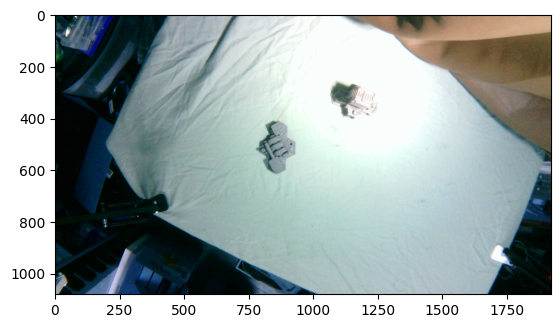

In [9]:
if __name__ == "__main__":
    cc = CaptureConfiguration()
    cc.capture()
    plt.imshow(cameras['0'].mostRecentFrame)

In [10]:
class Observer:
    """ Object to observe the state of its cameras and record changes """
    states = ["idle", "unstable", "classify"]
    modes = ["passive", "track"]
    observationThreshold = 3
    def __init__(self, captureConfiguration: CaptureConfiguration):
        self.cycleCounter = 0
        self.cc = captureConfiguration
        self.lastChanges = None
        self.lastClassification = None
        self.transitions = []
        self.memory = []
        self.lastMemory = None
        self.state = "idle"
        self.mode = "passive"
        self.cc.capture()
        self.cc.setBase()
        self.cc.setReference()
    
    def interactionDetection(self):
        detections = {cam.camName: cam.interactionDetection(cam.mostRecentFrame) for cam in cameras.values()}
        return sum(detections.values()) > 0
    
    def updateReference(self):
        self.cc.setReference()
        
    def referenceFrameDeltas(self):
        return ChangeSet({camName: cam.referenceFrameDelta() for camName, cam in cameras.items()})

    def camCommitChange(self, classifiedChange):
        overlaps = self.changeOverlaps(classifiedChange)
        assert classifiedChange.changeType != "unclassified", "Unable to commit unclassified changes"
        if classifiedChange.changeType == None:
            print(f"Cam {self.camName} - Nothing to commit")
        elif classifiedChange.changeType == "add":
            print(f"Cam {self.camName} - Adding {classifiedChange}")
            self.changes.insert(0, classifiedChange)
        elif classifiedChange.changeType == "move":
            print(f"Cam {self.camName} - Moving {classifiedChange.lastChange} to {classifiedChange}")
            self.changes.remove(classifiedChange.lastChange)
            self.changes.insert(0, classifiedChange)
        elif classifiedChange.changeType == "delete":
            print(f"Cam {self.camName} - Deleting {classifiedChange.lastChange} with {classifiedChange}")
            self.changes.remove(classifiedChange.lastChange)
        else:
            raise Exception(f"Cam {self.camName} - Unrecognzed changeType: {classifiedChange}")

    def commitChanges(self, objDef):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            print(f"Updating Memory {existingIndex}")
            objDef.oid = self.memory[existingIndex].oid
            self.memory[existingIndex] = objDef
        except ValueError:
            print(f"New Memory")
            self.memory.append(objDef)
        self.lastMemory = objDef
        
        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camName: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camName, cam in cameras.items()}})
    
    def memoriesInChangeOrder(self):
        changeOrderMemories = []
        if not self.transitions:
            return changeOrderMemories
        for transition in self.transitions[::-1]:
            if transition['obj'] not in changeOrderMemories:
                changeOrderMemories.append(transition['obj'])
                if len(changeOrderMemories) == len(self.memory):
                    return changeOrderMemories
        raise Exception("Failed to reconstruct memories in change order")
    
    def changeOverlaps(self, camera, change):
        changes = [m.changeSet[camera.camName] for m in self.memory]
        overlaps = []
        for eC in changes:
            if eC.changeType is not None and eC.changeOverlap(change) and eC not in overlaps:
                overlaps.append(eC)
        return overlaps

    def classifyCameraChange(self, camera, change: CameraChange):
        if change.changeType is None:
            return change

        overlaps = self.changeOverlaps(camera, change)
        if len(overlaps) == 0:  # Addition
            change.classify("add", CameraChange(None, None, None, None, None))
            return change
        elif len(overlaps) == 1:  # Move or Deletion
            cPD = camera.changePatchDelta(overlaps[0])
            if cPD.changeType is not None:  # Move
                patchedOverlaps = [o for o in self.changeOverlaps(camera, cPD) if o != overlaps[0]]
                if len(patchedOverlaps) != 0:
                    raise Exception(f"Unable to classify change: {change} interacting with {overlaps[0]} (patch has overlaps: {patchedOverlaps}")
                cPD.classify("move", overlaps[0])
                return cPD
            else:  # cPD == [], Deletion
                change.classify("delete", overlaps[0])
                return change
        else:
            raise Exception(f"Unable to classify change: {change}")

    def classifyChanges(self, changes):
        objDef = {}
        for camName, change in changes.changeSet.items():
            if change is not None:
                objDef[camName] = self.classifyCameraChange(cameras[camName], change)
            else:
                objDef[camName] = None
        return TrackedObject(objDef)

    def deleteObject(self, oid):
        memCaps = {cap.oid: cap for cap in self.memory}
        if oid in memCaps:
            cap = memCaps[oid]
            self.memory.remove(cap)
        self.lastMemory = {"deletedObject": oid}
        self.passiveMode()
    
    def cycle(self):
        minimumClassificationTime = 2
        cycleStart = datetime.utcnow()
        try:
            print(f"Starting Cycle {self.cycleCounter:5} -- {self}")
            nextState = "idle"
            self.cc.capture()
            changes = self.referenceFrameDeltas()
            classification = None
            if self.mode == "passive" or changes.empty:
                self.cc.setReference()
            else:
                nextState = "unstable"
                if changes == self.lastChanges:  
                    nextState = "classify"
                    classification = self.classifyChanges(changes)
                    if self.state == "classify" and classification == self.lastClassification:
                        try:
                            nextState = "idle"
                            self.commitChanges(classification)
                            self.cc.setReference()
                        except AssertionError as ae:
                            print(f"Failed Classification: {ae}")
                            nextState = "unstable"
                            classification = None
                    else:
                        cycleEnd = datetime.utcnow()
                        if (cycleTime := (cycleEnd - cycleStart).total_seconds()) < minimumClassificationTime:
                            sleep(minimumClassificationTime - cycleTime)
                        
            self.state = nextState
            self.cycleCounter += 1
            self.lastChanges = changes
            self.lastClassification = classification
            return None
        except:
            from traceback import format_exc
            print("CYCLE FAILURE!!!")
            print(format_exc())
            self.passiveMode()
            self.lastChanges = None
            self.lastClassification = None
            return "Cycle Failure"
    
    def trackMode(self):
        self.mode = "track"
    
    def passiveMode(self):
        self.mode = "passive"
            
    def cycleForChange(self):
        self.mode = "track"
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def __repr__(self):
        return f"CapMac -- {self.mode} {str(len(self.calibrationPts)) + ' ' if self.mode == 'calibrate' else ''}{self.state}"

Starting Cycle     0 -- CapMac -- passive idle


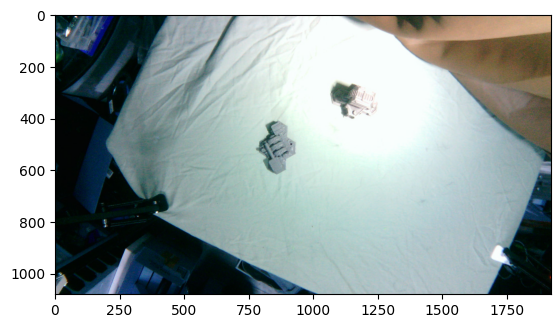

In [11]:
if __name__ == "__main__":
    o = Observer(cc)
    o.cycle()
    plt.imshow(cameras['0'].mostRecentFrame)

Starting Cycle    28 -- CapMac -- track idle
Starting Cycle    29 -- CapMac -- track idle
Starting Cycle    30 -- CapMac -- track idle
Starting Cycle    31 -- CapMac -- track idle
Starting Cycle    32 -- CapMac -- track idle
Starting Cycle    33 -- CapMac -- track unstable
Starting Cycle    34 -- CapMac -- track unstable
Starting Cycle    35 -- CapMac -- track unstable
Starting Cycle    36 -- CapMac -- track classify
Updating Memory 1


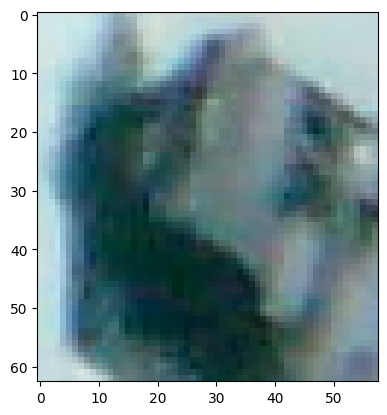

In [15]:
if __name__ == "__main__":
    o.cycleForChange()
    plt.imshow(o.memory[-1].visual())